In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
3
import random
import os
import pickle

import embiggen

import datetime

current_datetime = datetime.datetime.now()
formatted_date = current_datetime.strftime("%Y-%m-%d_%H_%M_%S")
print(formatted_date)

2024-11-23_19_40_21


In [168]:
!pip list | grep pandas

pandas                                   2.2.2

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [169]:
!pip list | grep numpy

numpy                                    1.26.0

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
RANDOM_SEED = 12
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_seed = random.seed
print(random.seed)
print(np.random.get_state())

<bound method Random.seed of <random.Random object at 0x0000023375E29320>>
('MT19937', array([        12,  274362557, 2871959443,   96505144, 3440553756,
       3320819264, 1671863157, 2853726411, 3576948821, 2267721719,
       1471449267,  205467717,  329644101, 2017124422,  120683281,
       3671631556, 3425389459, 2306138081, 2854342561, 2833917538,
       2139784180, 1777806526, 3803176561, 3129722129, 3441486743,
       1830495613, 3911788038,  683126036, 2275605760, 2143413223,
       1841233884, 3193124688, 3131946362,  854446201,  464715999,
       3543117598, 3696335765,  563062867, 3171341285, 2053716298,
       3493445055, 2373285717, 2744558717, 1005575494, 2549531338,
       3054493973,  794434881,  553407444, 3342173908, 2703770116,
       1986085520, 3203783784, 2832904198,  647337417,  715893123,
       2584083430,  191194412,  374961813, 3419702787, 3499023931,
       1892787284,  234508998, 1165532764, 2246131696,  884260026,
        627310499,   95884945,  105283704,

In [ ]:
data = pd.read_csv("../merged-kg_edges.tsv", header=0, sep="\t")

C:\Users\Dominika\AppData\Local\Temp\ipykernel_14684\1597539140.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("merged-kg_edges.tsv", header=0, sep="\t")


In [ ]:
data_nodes = pd.read_csv("../merged-kg_nodes.tsv", header=0, sep="\t")

C:\Users\Dominika\AppData\Local\Temp\ipykernel_14684\1983804780.py:1: DtypeWarning: Columns (3,4,6,7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_nodes = pd.read_csv("merged-kg_nodes.tsv", header=0, sep="\t")


In [5]:
data_nodes

,id,category,name,description,xref,provided_by,synonym,deprecated,iri,object,predicate,relation,same_as,subject,subsets
0,IAO:0000115,biolink:OntologyClass,definition,NaN,NaN,Graph,NaN,NaN,http://purl.obolibrary.org/obo/IAO_0000115|htt...,NaN,NaN,NaN,NaN,NaN,NaN
1,NCBITaxon:1,biolink:EnvironmentalFeature|biolink:OrganismT...,root,NaN,GC_ID:1|PMID:30365038|PMID:32761142,Graph,all,NaN,http://purl.obolibrary.org/obo/NCBITaxon_1,NaN,NaN,NaN,NaN,NaN,NaN
2,NCBITaxon:10,biolink:OrganismTaxon,Cellvibrio,NaN,GC_ID:11|PMID:12710603|PMID:24105943,Graph,NaN,NaN,http://purl.obolibrary.org/obo/NCBITaxon_10,NaN,NaN,NaN,NaN,NaN,NaN
3,NCBITaxon:100,biolink:OrganismTaxon,Ancylobacter aquaticus,NaN,GC_ID:11,Graph,Microcyclus aquaticus,NaN,http://purl.obolibrary.org/obo/NCBITaxon_100,NaN,NaN,NaN,NaN,NaN,NaN
4,NCBITaxon:100000,biolink:OrganismTaxon,Herbaspirillum sp. BA12,NaN,GC_ID:11,Graph,Herbispirillum sp. BA12,NaN,http://purl.obolibrary.org/obo/NCBITaxon_100000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311864,trophic_type:copiotroph_diazotrophy,biolink:BiologicalProcess,copiotroph diazotroph,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311865,pigment:green,biolink:PhenotypicQuality,green pigment,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311866,temp_opt:very_low,biolink:PhenotypicQuality,optimal temperature <= 10 deg C,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311867,cell_shape:curved_spiral,biolink:NamedThing,NaN,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,temperature:mesophilic
4,NCBITaxon:100,medium:7
...,...,...
2473139,cell_shape:star_dumbbell_pleomorphic,cell_shape:pleomorphic
2473140,trophic_type:copiotroph_diazotrophy,trophic_type:copiotrophy
2473141,trophic_type:copiotroph_diazotrophy,trophic_type:diazotrophy
2473142,cell_shape:curved_spiral,cell_shape:curved


In [7]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32513, 2)

In [8]:
#TODO add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(142983, 2)

In [9]:
#TODO add closure
###
### ESPECIALLY for Taxonomy subClassOf >> one hot
###

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

#RELEVANT predicates

50357 biolink:assesses

126997 biolink:capable_of

127784 biolink:consumes

150279 biolink:has_phenotype

26755 biolink:location_of

32513 biolink:occurs_in

3692 biolink:produces

570848 biolink:related_to

830076 biolink:subclass_of

In [10]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrates:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('trophic_type:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('production:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('CAS-RN:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('CHEBI:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('EC:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('GO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_length:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_width:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('motility:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('sporulation:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pigment:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('gram_stain:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('gc:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pH_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('temp_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('temperature:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('salinity:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('NaCl_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('oxygen:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathogen:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('isolation_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('PO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest.shape

(401517, 2)

In [11]:
data_pairs_rest_all2 = data_pairs[data_pairs['object'].str.contains('NCBITaxon:')]
# Swap 'subject' and 'object' for the filtered DataFrame
data_pairs_rest_all2_swapped = data_pairs_rest_all2.copy()
data_pairs_rest_all2_swapped['subject'], data_pairs_rest_all2_swapped['object'] = data_pairs_rest_all2['object'], data_pairs_rest_all2['subject']
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('PATO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('FOODON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('CHEBI:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('PO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('API.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(404434, 2)

In [12]:
#data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
#data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_pairs_rest['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_pairs_rest.pivot_table(index='subject', columns='object', values='Value', aggfunc='sum', fill_value=0)
# Step 3: Fill NaN values with 0 to indicate no relationship
#data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:100147,CHEBI:10024,CHEBI:10057,CHEBI:115156,CHEBI:11986,CHEBI:125610,CHEBI:12931,CHEBI:12936,CHEBI:132106,CHEBI:132111,...,trophic_type:methanotrophy,trophic_type:methylotrophy,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:

# Assuming 'data_nodes' has a column 'id' for medium ID and 'label' for descriptions
# Filter out 'agar' containing media IDs
agar_media_ids = data_nodes[data_nodes['name'].str.contains('agar', case=False, na=False)]['id']

# Filter these IDs from data_pairs_clean
data_pairs_clean_filtered = data_pairs_clean[~data_pairs_clean['object'].isin(agar_media_ids)]

# Additional medium node IDs to exclude
medium_ids_to_exclude = ['medium:104', 'medium:1a', 'medium:215', 'medium:381', 'medium:545',
       'medium:553', 'medium:830c', 'medium:J12', 'medium:514c']

# Filter out media containing 'agar' or the additional IDs from data_nodes
media_ids_to_exclude = data_nodes[data_nodes['id'].isin(medium_ids_to_exclude)]['id']

# Filter these IDs from data_pairs_clean
data_pairs_clean_filtered = data_pairs_clean_filtered[~data_pairs_clean_filtered['object'].isin(media_ids_to_exclude)]

# Group by 'subject' and list all 'object' (medium)
taxon_media_groups = data_pairs_clean_filtered.groupby('subject')['object'].agg(list)

# Filter taxons with a single medium association
single_media_taxons = taxon_media_groups[taxon_media_groups.apply(len) == 1].apply(lambda x: x[0])

# Create DataFrame for single media counts
single_media_counts = data_pairs_clean_filtered[data_pairs_clean_filtered['object'].isin(single_media_taxons)].groupby('object').size()

# Prepare the final DataFrame with taxa that have a single medium assignment
final_df = single_media_taxons.reset_index()
final_df.columns = ['subject', 'MappedMedium']

# Rename 'subject' column to 'NCBITaxon' in final_df
final_df.rename(columns={'subject': 'NCBITaxon'}, inplace=True)
final_df.rename(columns={'MappedMedium': 'medium'}, inplace=True)
final_df.index = final_df['NCBITaxon']
final_df = final_df.drop(columns=['NCBITaxon'])

# Export to CSV
final_df.to_csv('taxa_media_mapping_adjusted.tsv', index=True, sep="\t")


In [14]:
final_df['medium'].value_counts().sum()

7743

In [15]:
print("Columns in data_df:", data_df.columns)
print("Columns in final_df:", final_df.columns)
print("Rows in data_df:", data_df.index)
print("Rows in final_df:", final_df.index)

Columns in data_df: Index(['CHEBI:100147', 'CHEBI:10024', 'CHEBI:10057', 'CHEBI:115156',
       'CHEBI:11986', 'CHEBI:125610', 'CHEBI:12931', 'CHEBI:12936',
       'CHEBI:132106', 'CHEBI:132111',
       ...
       'trophic_type:methanotrophy', 'trophic_type:methylotrophy',
       'trophic_type:mixotrophy', 'trophic_type:oligotrophy',
       'trophic_type:organoheterotrophy', 'trophic_type:organotrophy',
       'trophic_type:photoheterotrophy', 'trophic_type:photolithotrophy',
       'trophic_type:photoorganoheterotrophy', 'trophic_type:phototrophy'],
      dtype='object', name='object', length=1219)
Columns in final_df: Index(['medium'], dtype='object')
Rows in data_df: Index(['NCBITaxon:100', 'NCBITaxon:100053', 'NCBITaxon:1000560',
       'NCBITaxon:1000561', 'NCBITaxon:1000562', 'NCBITaxon:1000565',
       'NCBITaxon:1000566', 'NCBITaxon:1000567', 'NCBITaxon:1000568',
       'NCBITaxon:1000569',
       ...
       'NCBITaxon:999628', 'NCBITaxon:999629', 'NCBITaxon:999630',
       'NC

In [16]:
data_df = data_df.merge(final_df, left_index=True, right_index=True, how='left')
data_df

,CHEBI:100147,CHEBI:10024,CHEBI:10057,CHEBI:115156,CHEBI:11986,CHEBI:125610,CHEBI:12931,CHEBI:12936,CHEBI:132106,CHEBI:132111,...,trophic_type:methylotrophy,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1113
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [17]:
data_df.columns

Index(['CHEBI:100147', 'CHEBI:10024', 'CHEBI:10057', 'CHEBI:115156',
       'CHEBI:11986', 'CHEBI:125610', 'CHEBI:12931', 'CHEBI:12936',
       'CHEBI:132106', 'CHEBI:132111',
       ...
       'trophic_type:methylotrophy', 'trophic_type:mixotrophy',
       'trophic_type:oligotrophy', 'trophic_type:organoheterotrophy',
       'trophic_type:organotrophy', 'trophic_type:photoheterotrophy',
       'trophic_type:photolithotrophy', 'trophic_type:photoorganoheterotrophy',
       'trophic_type:phototrophy', 'medium'],
      dtype='object', length=1220)

In [18]:
#MappedMedium
data_df['medium'].value_counts().sum()

7644

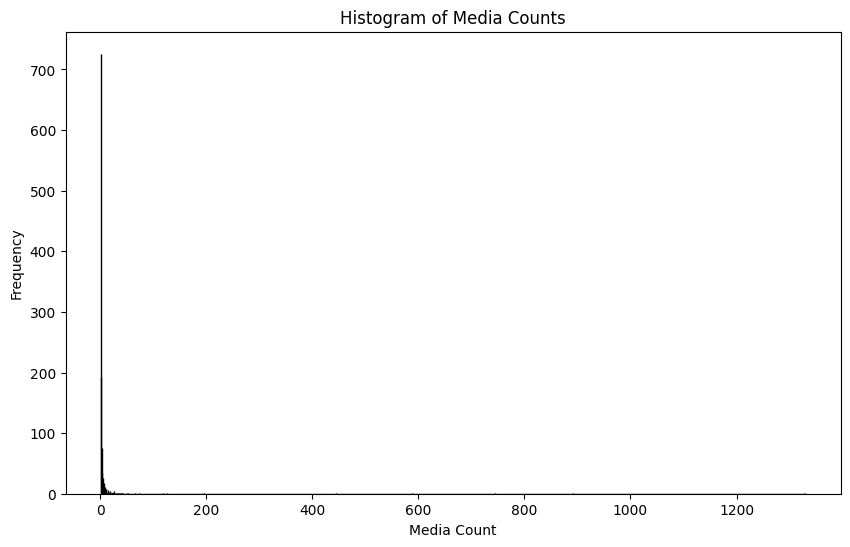

In [19]:
# Assuming data_pairs_clean_filtered['MediaCount'] exists and is populated with the occurrence counts of each medium
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.hist(data_df['medium'].value_counts(), bins='auto', color='skyblue', edgecolor='black')
plt.title('Histogram of Media Counts')
plt.xlabel('Media Count')
plt.ylabel('Frequency')

plt.show()

In [20]:
# Create the subject_object_mapping from the final_df
#subject_object_mapping = final_df.set_index('subject')['MappedMedium'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
#data_df['medium'] = data_df.index.map(subject_object_mapping)


In [21]:
data_df['medium'].isna().sum()

32002

In [22]:
data_df['medium'].value_counts()[0:19]


medium
medium:514      1330
medium:830       891
medium:65        744
medium:92        588
medium:693       445
medium:11        195
medium:645       125
medium:J14       118
medium:1076b      73
medium:J574       65
medium:58         52
medium:98         51
medium:104b       43
medium:63         40
medium:110        39
medium:535b       37
medium:1560       35
medium:27         34
medium:554        32
Name: count, dtype: int64

In [23]:
data_df['medium'].value_counts()

medium
medium:514     1330
medium:830      891
medium:65       744
medium:92       588
medium:693      445
               ... 
medium:503e       1
medium:866        1
medium:471        1
medium:J111       1
medium:1631       1
Name: count, Length: 1164, dtype: int64

In [24]:
data_df['medium'][data_df['medium'].notna()]

subject
NCBITaxon:100053      medium:1113
NCBITaxon:1000566     medium:1504
NCBITaxon:1001         medium:668
NCBITaxon:1001240       medium:92
NCBITaxon:100133       medium:860
                         ...     
NCBITaxon:999550       medium:514
NCBITaxon:999552       medium:514
NCBITaxon:999611       medium:514
NCBITaxon:999894     medium:1210a
NCBITaxon:999931        medium:65
Name: medium, Length: 7644, dtype: object

In [25]:
data_df['medium'].notna().sum()

7644

In [26]:
data_df_orig = data_df.copy()


In [27]:
#data_df = data_df_orig
data_df = data_df[data_df['medium'].notna()]
data_df

,CHEBI:100147,CHEBI:10024,CHEBI:10057,CHEBI:115156,CHEBI:11986,CHEBI:125610,CHEBI:12931,CHEBI:12936,CHEBI:132106,CHEBI:132111,...,trophic_type:methylotrophy,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1113
NCBITaxon:1000566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1504
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:668
NCBITaxon:1001240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514


In [28]:
index_series = pd.Series(data_df.index.values)

# Save this series to TSV file
index_series.to_csv('data_df__taxa_to_media__NCBITaxon__traingreat39_filtervar0.015_iterate.tsv', sep='\t', index=False, header=False)

In [29]:

# Extracting unique values from the 'medium' column
unique_mediums = data_df['medium'].unique()

len(unique_mediums)


1164

In [30]:
data_df['medium'][data_df['medium'] == 'medium:65']

subject
NCBITaxon:1003110    medium:65
NCBITaxon:1007097    medium:65
NCBITaxon:102227     medium:65
NCBITaxon:1036182    medium:65
NCBITaxon:103728     medium:65
                       ...    
NCBITaxon:985760     medium:65
NCBITaxon:987045     medium:65
NCBITaxon:988821     medium:65
NCBITaxon:994479     medium:65
NCBITaxon:999931     medium:65
Name: medium, Length: 744, dtype: object

In [31]:
data_df['medium'].value_counts()

medium
medium:514     1330
medium:830      891
medium:65       744
medium:92       588
medium:693      445
               ... 
medium:503e       1
medium:866        1
medium:471        1
medium:J111       1
medium:1631       1
Name: count, Length: 1164, dtype: int64

In [32]:
total_sum_numeric = data_df.select_dtypes(include=['number']).sum().sum()
print(total_sum_numeric)
data_df.shape

135242


(7644, 1220)

In [33]:
data_df_clean = data_df.copy()
print(data_df_clean.shape)
# Step 1: Select only the numerical columns (excluding 'medium')
numerical_data = data_df_clean.select_dtypes(include=np.number)

# Add the 'medium' column back for grouping
if 'medium' not in numerical_data.columns:
    numerical_data['medium'] = data_df_clean['medium']

for col in numerical_data.columns[:-1]:  # Exclude 'medium' from filling NaNs
    numerical_data[col].fillna(0, inplace=True)

# Check how many entries exist for 'medium:65' before melting
pre_melt_count = numerical_data[numerical_data['medium'] == 'medium:65'].shape[0]
print(f"Count of 'medium:65' entries before melting: {pre_melt_count}")


# Step 2: Melt the dataframe to long format
melted_data = numerical_data.melt(id_vars='medium', var_name='Feature', value_name='Value')


# Print the head of the melted data to check its structure
print(melted_data.head())

# Check unique mediums in the melted data
print("Unique mediums in melted data:", melted_data['medium'].unique())


# Step 3: Group by 'medium' and calculate variance across all features for each class
class_variance = melted_data.groupby('medium')['Value'].var().reset_index(name='Variance')

# Print the output of the variance calculation
print(class_variance)

# Check if any mediums are being dropped inadvertently
if 'medium:65' not in class_variance['medium'].values:
    print("medium:65 is missing from variance calculation!")


print(class_variance)


(7644, 1220)


C:\Users\Dominika\AppData\Local\Temp\ipykernel_14684\3647623217.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  numerical_data[col].fillna(0, inplace=True)


Count of 'medium:65' entries before melting: 744
        medium       Feature  Value
0  medium:1113  CHEBI:100147      0
1  medium:1504  CHEBI:100147      0
2   medium:668  CHEBI:100147      0
3    medium:92  CHEBI:100147      0
4   medium:860  CHEBI:100147      0
Unique mediums in melted data: ['medium:1113' 'medium:1504' 'medium:668' ... 'medium:460' 'medium:923'
 'medium:J144']
           medium  Variance
0       medium:10  0.002457
1     medium:1001  0.004902
2     medium:1002  0.006525
3     medium:1003  0.026360
4     medium:1004  0.020490
...           ...       ...
1159  medium:J964  0.020105
1160  medium:J968  0.002457
1161   medium:J97  0.004434
1162  medium:J976  0.016151
1163  medium:J992  0.005170

[1164 rows x 2 columns]
           medium  Variance
0       medium:10  0.002457
1     medium:1001  0.004902
2     medium:1002  0.006525
3     medium:1003  0.026360
4     medium:1004  0.020490
...           ...       ...
1159  medium:J964  0.020105
1160  medium:J968  0.002457
116

In [34]:
melted_data['medium'][melted_data['medium'] == 'medium:65']

#print(class_variance['medium:65'])


13         medium:65
28         medium:65
51         medium:65
86         medium:65
89         medium:65
             ...    
9317973    medium:65
9317978    medium:65
9317983    medium:65
9318002    medium:65
9318035    medium:65
Name: medium, Length: 906936, dtype: object

In [35]:
class_variance[class_variance['medium'] == 'medium:65']

,medium,Variance
720,medium:65,0.015139


In [36]:
# Check the total entries for 'medium:65' after melting
post_melt_count = melted_data[melted_data['medium'] == 'medium:65'].shape[0]
print(f"Count of 'medium:65' entries after melting: {post_melt_count}")


Count of 'medium:65' entries after melting: 906936


In [37]:
# Print detailed statistics for 'medium:65' to understand the data spread
print(numerical_data[numerical_data['medium'] == 'medium:65'].describe())

# Additionally, check for any duplicates or unexpected entries
print("Check for duplicates in pre-melt data for 'medium:65':", numerical_data[numerical_data['medium'] == 'medium:65'].duplicated().sum())


       CHEBI:100147  CHEBI:10024  CHEBI:10057  CHEBI:115156  CHEBI:11986  \
count    744.000000        744.0        744.0         744.0        744.0   
mean       0.004032          0.0          0.0           0.0          0.0   
std        0.063415          0.0          0.0           0.0          0.0   
min        0.000000          0.0          0.0           0.0          0.0   
25%        0.000000          0.0          0.0           0.0          0.0   
50%        0.000000          0.0          0.0           0.0          0.0   
75%        0.000000          0.0          0.0           0.0          0.0   
max        1.000000          0.0          0.0           0.0          0.0   

       CHEBI:125610  CHEBI:12931  CHEBI:12936  CHEBI:132106  CHEBI:132111  \
count    744.000000        744.0   744.000000         744.0         744.0   
mean       0.001344          0.0     0.032258           0.0           0.0   
std        0.036662          0.0     0.176804           0.0           0.0   
min    

In [38]:
# Calculate expected post-melt count
expected_post_melt_count = pre_melt_count * (numerical_data.shape[1] - 1)  # Exclude 'medium' column
print(f"Expected count of 'medium:65' entries after melting: {expected_post_melt_count}")


Expected count of 'medium:65' entries after melting: 906936


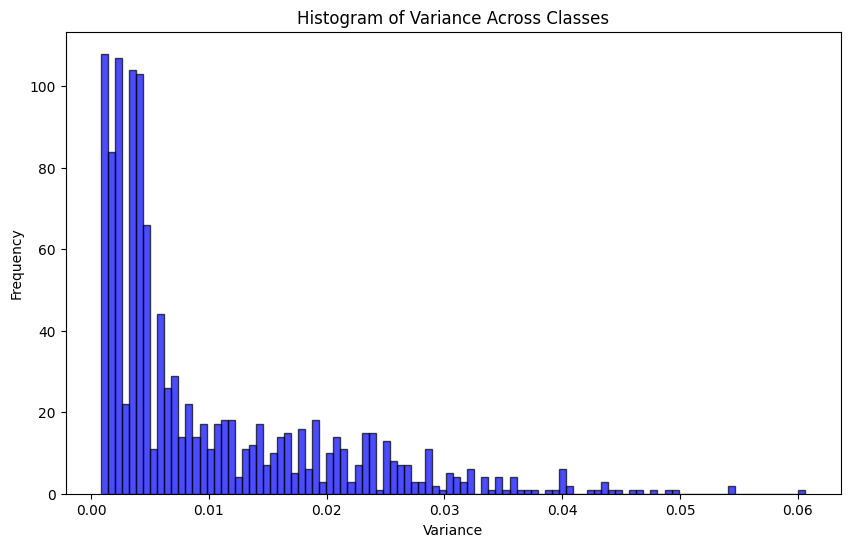

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(class_variance['Variance'], bins=100, alpha=0.7, color='blue', edgecolor='black')

plt.title('Histogram of Variance Across Classes')
plt.xlabel('Variance')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [40]:
# Step 1: Identify classes with variance > X
classes_to_exclude = class_variance[class_variance['Variance'] > 0.015]
# Step 2: Filter out these classes from data_df_clean
print(data_df_clean.shape)
data_df_clean = data_df_clean[~data_df_clean['medium'].isin(classes_to_exclude)]
data_df_clean

(7644, 1220)


,CHEBI:100147,CHEBI:10024,CHEBI:10057,CHEBI:115156,CHEBI:11986,CHEBI:125610,CHEBI:12931,CHEBI:12936,CHEBI:132106,CHEBI:132111,...,trophic_type:methylotrophy,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1113
NCBITaxon:1000566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1504
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:668
NCBITaxon:1001240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514


In [41]:
# Select only numeric columns for the operation
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns

# Remove columns with sum < 1, excluding the 'medium' column or any other non-numeric columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 <= 1]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)

#Remove cols which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 == dimnow[1]]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)


# Correct the approach to remove rows with sum < 1, ensuring to only sum over the updated numeric columns
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
rows_to_drop = data_df_clean.index[sum_less2_row <= 1]
data_df_clean = data_df_clean.drop(index=rows_to_drop)

#Remove rows which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
#print(sum_less2_row[sum_less2_row == dimnow[0]])
rows_to_drop = data_df_clean.index[sum_less2_row == dimnow[0]]
#print(rows_to_drop)
data_df_clean = data_df_clean.drop(index=rows_to_drop)
print(dimnow)

data_df_clean

(7644, 1220)
(7644, 713)
(7644, 713)
(6731, 713)
(6731, 713)


,CHEBI:100147,CHEBI:10057,CHEBI:115156,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,...,trophic_type:chemotrophy,trophic_type:copiotroph_diazotrophy,trophic_type:heterotrophy,trophic_type:lithoheterotrophy,trophic_type:lithotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1113
NCBITaxon:1000566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:1504
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:668
NCBITaxon:1001240,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514


In [42]:
data_df['medium'].value_counts()

medium
medium:514     1330
medium:830      891
medium:65       744
medium:92       588
medium:693      445
               ... 
medium:503e       1
medium:866        1
medium:471        1
medium:J111       1
medium:1631       1
Name: count, Length: 1164, dtype: int64

In [43]:
#data_df_clean = data_df.copy()
data_df_clean = data_df_clean.groupby('medium').filter(lambda x : len(x)>39)

data_df_clean

,CHEBI:100147,CHEBI:10057,CHEBI:115156,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,...,trophic_type:chemotrophy,trophic_type:copiotroph_diazotrophy,trophic_type:heterotrophy,trophic_type:lithoheterotrophy,trophic_type:lithotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1001240,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,medium:92
NCBITaxon:1003110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:65
NCBITaxon:1004279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:98
NCBITaxon:1004304,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:830
NCBITaxon:1004316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium:514


In [44]:
data_df['medium'].value_counts()

medium
medium:514     1330
medium:830      891
medium:65       744
medium:92       588
medium:693      445
               ... 
medium:503e       1
medium:866        1
medium:471        1
medium:J111       1
medium:1631       1
Name: count, Length: 1164, dtype: int64

In [45]:
# Select only numeric columns for the operation
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns

# Remove columns with sum < 1, excluding the 'medium' column or any other non-numeric columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 <= 1]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)

#Remove cols which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 == dimnow[1]]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)


# Correct the approach to remove rows with sum < 1, ensuring to only sum over the updated numeric columns
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
rows_to_drop = data_df_clean.index[sum_less2_row <= 1]
data_df_clean = data_df_clean.drop(index=rows_to_drop)

#Remove rows which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
#print(sum_less2_row[sum_less2_row == dimnow[0]])
rows_to_drop = data_df_clean.index[sum_less2_row == dimnow[0]]
#print(rows_to_drop)
data_df_clean = data_df_clean.drop(index=rows_to_drop)
print(dimnow)

data_df_clean

(4103, 713)
(4103, 578)
(4103, 578)
(4103, 578)
(4103, 578)


,CHEBI:100147,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,CHEBI:14314,CHEBI:14336,...,temperature:mesophilic,temperature:psychrophilic,temperature:thermophilic,trophic_type:chemoheterotrophy,trophic_type:chemoorganoheterotrophy,trophic_type:chemoorganotrophy,trophic_type:chemotrophy,trophic_type:heterotrophy,trophic_type:organotrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1001240,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:92
NCBITaxon:1003110,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:65
NCBITaxon:1004279,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:98
NCBITaxon:1004304,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,medium:830
NCBITaxon:1004316,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514


In [46]:
patterns = {}
columns_to_drop = []
retention_map = {}

# Iterate over columns
for col in data_df_clean.columns:
    pattern = tuple(data_df_clean[col])
    if pattern not in patterns:
        patterns[pattern] = col
        retention_map[col] = []  # Initialize the list of dropped columns for this pattern
    else:
        # Add the current column to the drop list and map it to the retained column
        columns_to_drop.append(col)
        retention_map[patterns[pattern]].append(col)

# Drop duplicate columns
data_df_clean = data_df_clean.drop(columns=columns_to_drop)

# Prepare to write the mapping to a file
retention_df = pd.DataFrame(
    [(retained, ','.join(duplicates)) for retained, duplicates in retention_map.items() if duplicates],
    columns=['Retained Column', 'Deleted Columns']
)

# Write to CSV file
retention_df.to_csv('kg_microbe_train_tax_to_media__traingreat39_filtervar0.015_iterate.csv', index=False)

# Display what was saved to file
retention_df

,Retained Column,Deleted Columns
0,CHEBI:133748,CHEBI:50744
1,CHEBI:16632,CHEBI:29749
2,CHEBI:30796,CHEBI:30797
3,CHEBI:32892,"CHEBI:41808,CHEBI:45296"
4,GO:0015946,pathways:methylotrophy
5,pathways:aerobic_anoxygenic_phototrophy,pathways:photoheterotrophy
6,pathways:aerobic_heterotrophy,"pathways:nitrate_reduction_to_ammonia,pathways..."


In [47]:
data_df_clean

,CHEBI:100147,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,CHEBI:14314,CHEBI:14336,...,temperature:mesophilic,temperature:psychrophilic,temperature:thermophilic,trophic_type:chemoheterotrophy,trophic_type:chemoorganoheterotrophy,trophic_type:chemoorganotrophy,trophic_type:chemotrophy,trophic_type:heterotrophy,trophic_type:organotrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1001240,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:92
NCBITaxon:1003110,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:65
NCBITaxon:1004279,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:98
NCBITaxon:1004304,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,medium:830
NCBITaxon:1004316,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514


In [48]:
file_path = 'taxa_to_media__traingreat39_filtervar0.015_iterate__data_df_clean.tsv.gz'
data_df_clean.to_csv(file_path, sep='\t', index=True, header=True, compression='gzip')


In [49]:
data_df_clean_load = pd.read_csv('taxa_to_media__traingreat39_filtervar0.015_iterate__data_df_clean.tsv.gz', compression='gzip', sep='\t', index_col=0, header=0)
data_df_clean_load

,CHEBI:100147,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,CHEBI:14314,CHEBI:14336,...,temperature:mesophilic,temperature:psychrophilic,temperature:thermophilic,trophic_type:chemoheterotrophy,trophic_type:chemoorganoheterotrophy,trophic_type:chemoorganotrophy,trophic_type:chemotrophy,trophic_type:heterotrophy,trophic_type:organotrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1001240,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:92
NCBITaxon:1003110,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:65
NCBITaxon:1004279,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:98
NCBITaxon:1004304,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,medium:830
NCBITaxon:1004316,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,medium:514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,medium:514


In [50]:
# Splitting the data into features and target labels
X = data_df_clean.drop('medium', axis=1)#data_pairs_clean_filtered[['subject']]
y = data_df_clean['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [51]:
len(set(data_df_clean['medium']))

10

In [52]:
len(set(data_df['medium']))

1164

In [53]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=RANDOM_SEED)

train_data = Pool(data=X_train, label=y_train, cat_features=[])
val_data = Pool(data=X_val, label=y_val, cat_features=[])
test_data = Pool(data=X_test, label=y_test, cat_features=[])

In [54]:
#6908
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2872, 568)
(824, 568)
(407, 568)


In [ ]:
#save the test and val files
X_test.to_csv("test.tsv", sep='\t', index=True)
y_test.to_csv("y_test.tsv", sep='\t', index=True)

X_val.to_csv("val.tsv", sep='\t', index=True)
y_val.to_csv("y_val.tsv", sep='\t', index=True)

In [56]:
%%time
model = CatBoostClassifier(random_seed=RANDOM_SEED,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.05,#0.001
                           depth=4,
                           l2_leaf_reg=4,
                           bagging_temperature=1,
                           random_strength=6,
                           verbose=100)
model.fit(train_data, 
          eval_set=val_data,
          early_stopping_rounds=50 
         )#, plot=True)

0:	learn: 2.2538411	test: 2.2546133	best: 2.2546133 (0)	total: 167ms	remaining: 27m 52s
100:	learn: 1.3943114	test: 1.4355567	best: 1.4355567 (100)	total: 1.52s	remaining: 2m 29s
200:	learn: 1.1200036	test: 1.1903908	best: 1.1903908 (200)	total: 2.87s	remaining: 2m 19s
300:	learn: 0.9245099	test: 1.0250805	best: 1.0250805 (300)	total: 4.21s	remaining: 2m 15s
400:	learn: 0.8397343	test: 0.9585568	best: 0.9585568 (400)	total: 5.57s	remaining: 2m 13s
500:	learn: 0.7931799	test: 0.9263731	best: 0.9263731 (500)	total: 7.03s	remaining: 2m 13s
600:	learn: 0.7582149	test: 0.9047266	best: 0.9047266 (600)	total: 8.32s	remaining: 2m 10s
700:	learn: 0.7309578	test: 0.8893182	best: 0.8893093 (698)	total: 9.64s	remaining: 2m 7s
800:	learn: 0.7080985	test: 0.8768432	best: 0.8767972 (798)	total: 11s	remaining: 2m 6s
900:	learn: 0.6881930	test: 0.8665009	best: 0.8665009 (900)	total: 12.5s	remaining: 2m 6s
1000:	learn: 0.6697234	test: 0.8569815	best: 0.8569815 (1000)	total: 14.3s	remaining: 2m 8s
1100:	

In [57]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))  # Adding balanced accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.7223587223587223
Balanced Accuracy: 0.6597532118436074

Classification Report:
               precision    recall  f1-score   support

medium:1076b       1.00      0.83      0.91         6
   medium:11       0.86      0.67      0.75        18
  medium:514       0.75      0.91      0.82       118
  medium:645       0.62      0.45      0.53        11
   medium:65       0.68      0.85      0.76        66
  medium:693       0.78      0.69      0.73        42
  medium:830       0.73      0.60      0.66        81
   medium:92       0.59      0.44      0.51        52
   medium:98       0.67      0.40      0.50         5
  medium:J14       0.60      0.75      0.67         8

    accuracy                           0.72       407
   macro avg       0.73      0.66      0.68       407
weighted avg       0.72      0.72      0.71       407



In [58]:

# Save the model to a file
model.save_model('catboost_model_kg_microbe_train_taxa_to_media__traingreat39_filtervar0.015_iterate_'+formatted_date+'.cbm')


#loaded_model = CatBoostClassifier()  # or CatBoostRegressor() depending on your model type
#loaded_model.load_model('catboost_model.cbm')

In [59]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter rows where both precision and recall are greater than 0.9
# Note: Precision and recall are not defined for the 'accuracy' row, so we exclude it from the filter
report_filtered_df = report_df[(report_df['precision'] > 0.9) & (report_df['recall'] > 0.9)]# & (report_df.index != 'accuracy')]

# Print out the filtered rows
report_filtered_df

,precision,recall,f1-score,support


In [60]:
report_df[(report_df['precision'] > 0.8) & (report_df['recall'] > 0.5)]

,precision,recall,f1-score,support
medium:1076b,1.000000,0.833333,0.909091,6.0
medium:11,0.857143,0.666667,0.750000,18.0


In [61]:
report_df[(report_df['precision'] == 0) & (report_df['recall'] == 0)].index

Index([], dtype='object')

In [62]:
report_df[(report_df['precision'] < 0.5)].index

Index([], dtype='object')

In [63]:
report_filtered_80_df = report_df[(report_df['precision'] > 0.8) & (report_df['recall'] > 0.5)]# & (report_df.index != 'accuracy')]

# Print out the filtered rows
print(report_filtered_80_df)

              precision    recall  f1-score  support
medium:1076b   1.000000  0.833333  0.909091      6.0
medium:11      0.857143  0.666667  0.750000     18.0


In [64]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Balanced Accuracy:", balanced_accuracy_score(y_train, y_pred_train))  # Adding balanced accuracy
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.8582869080779945
Balanced Accuracy: 0.8501728966045399

Classification Report:
               precision    recall  f1-score   support

medium:1076b       0.77      0.84      0.80        44
   medium:11       0.97      0.94      0.96       126
  medium:514       0.81      0.95      0.88       831
  medium:645       0.86      0.85      0.86        80
   medium:65       0.80      0.91      0.85       463
  medium:693       0.93      0.86      0.90       297
  medium:830       0.91      0.76      0.83       573
   medium:92       0.89      0.71      0.79       367
   medium:98       0.96      0.79      0.87        34
  medium:J14       0.94      0.88      0.91        57

    accuracy                           0.86      2872
   macro avg       0.89      0.85      0.86      2872
weighted avg       0.87      0.86      0.86      2872



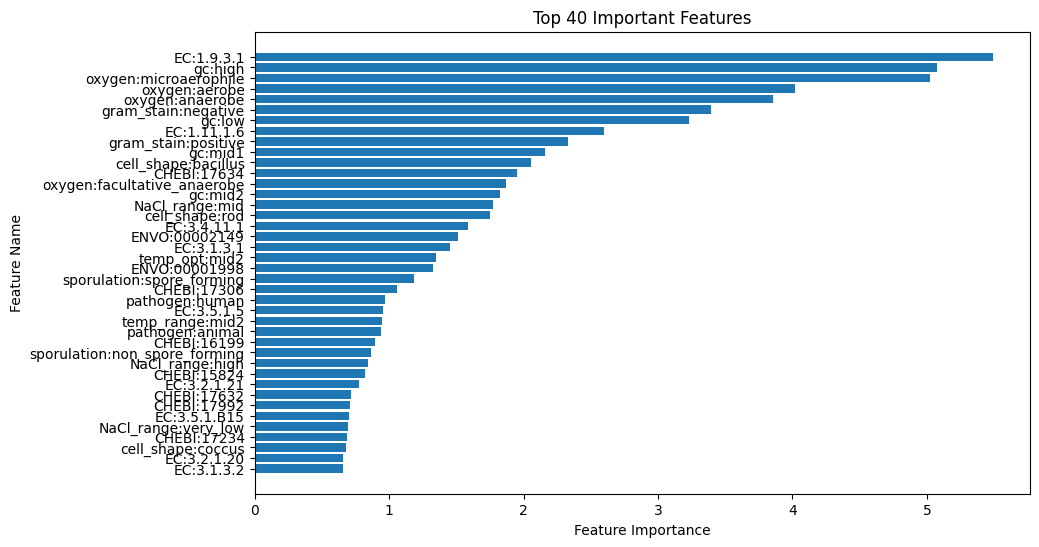

In [65]:
feature_importances = model.get_feature_importance()

# Assuming your feature names are stored in a list 'feature_names'
feature_names = X_test.columns.values#['feature1', 'feature2', ..., 'featureN']

# Create a list of (feature_name, importance) tuples
feature_importance_tuples = [(name, importance) for name, importance in zip(feature_names, feature_importances)]

# Sort the feature importances in descending order and take the top 10
topn = 40
top_100_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)[:topn]

# Separate the feature names and their importances
top_features, top_importances = zip(*top_100_features)

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top '+str(topn)+' Important Features')

figure_name = "top_"+str(topn)+"_features_catboost__traingreat39_filtervar0.015_iterate.pdf"
# Save the figure as a PDF
plt.savefig(f"{figure_name}.pdf", format='pdf', bbox_inches='tight')

# Save the figure as a PNG
plt.savefig(f"{figure_name}.png", format='png', bbox_inches='tight')

plt.show()

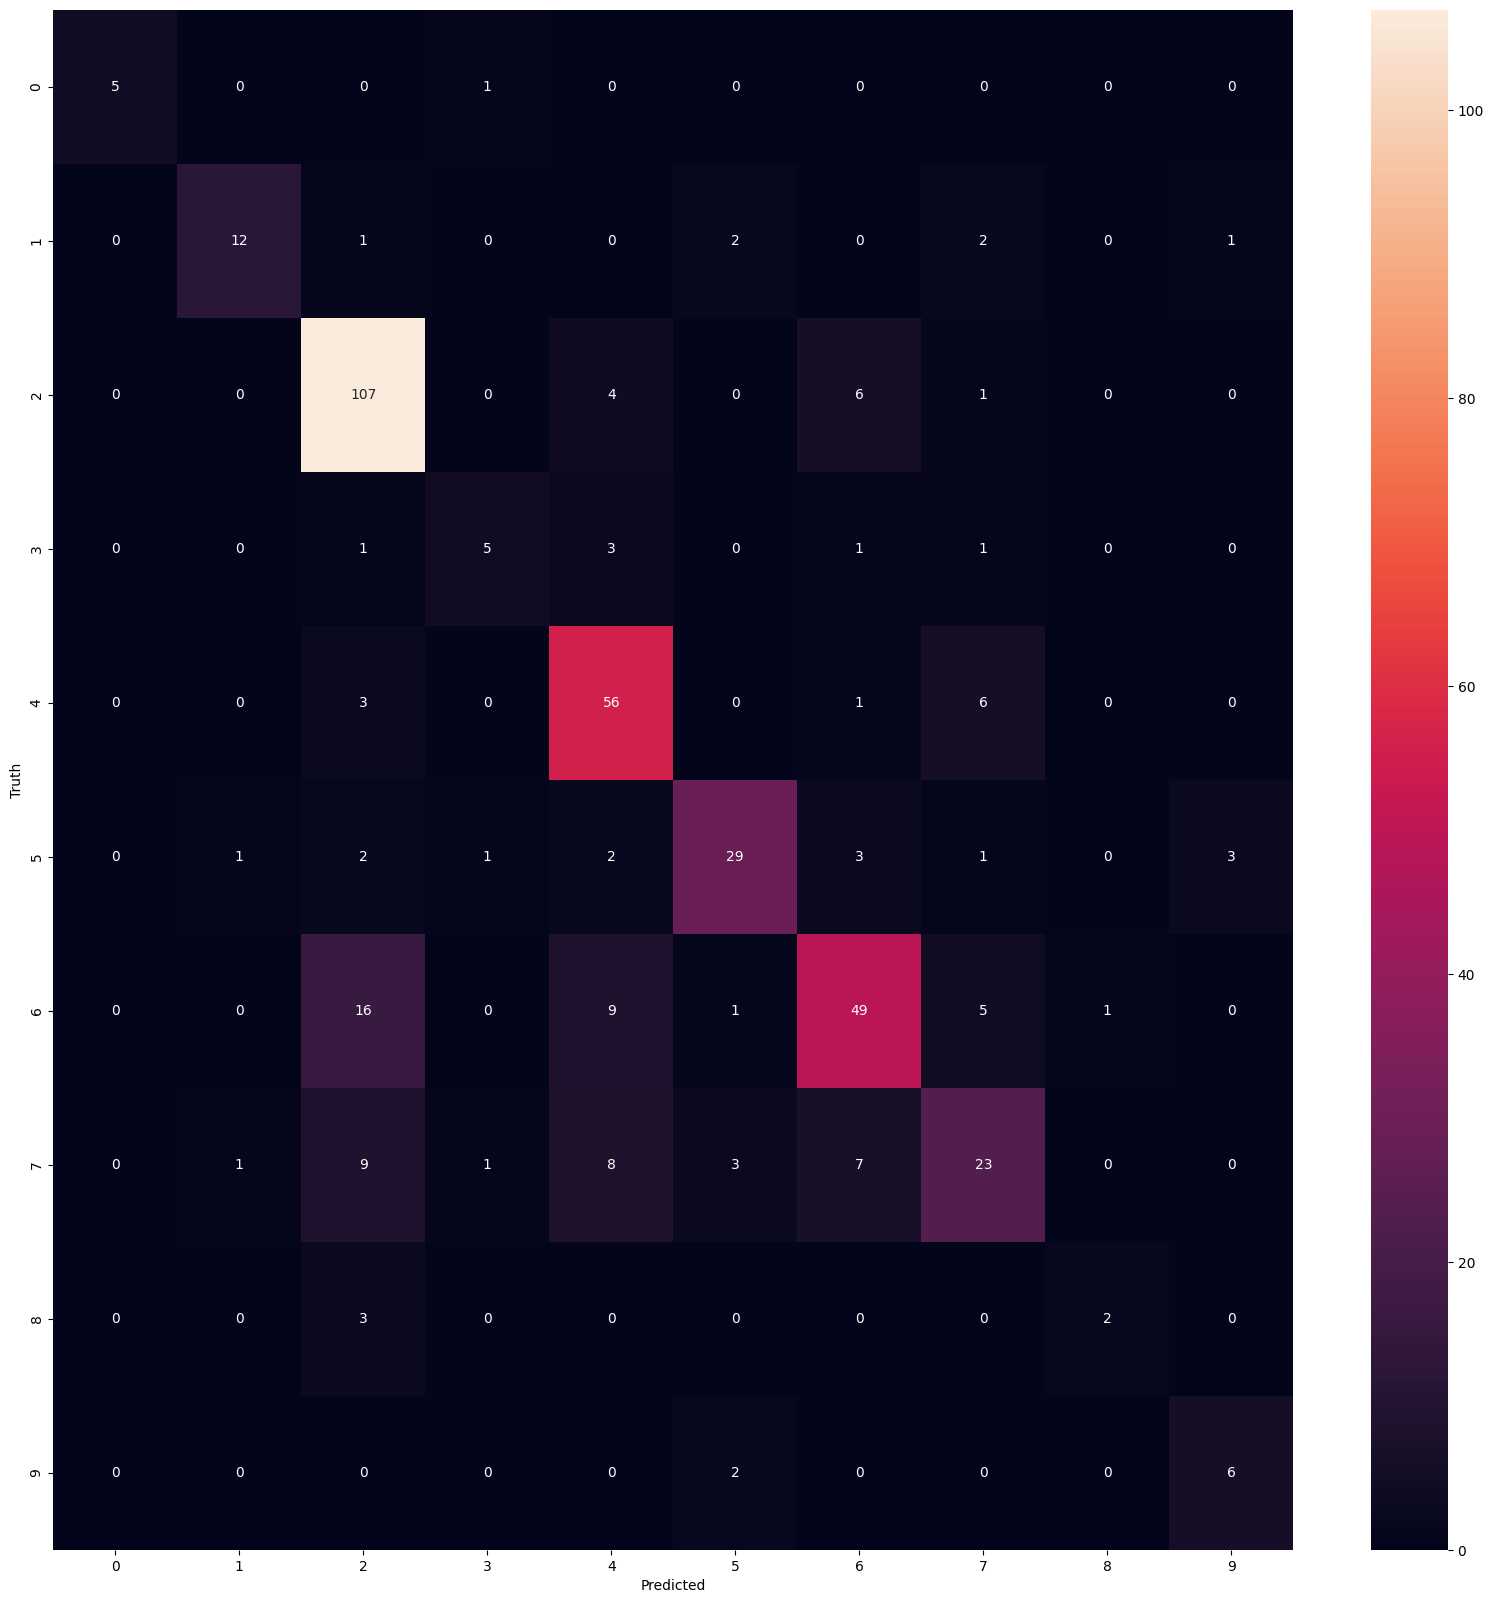

In [66]:
# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion_'+formatted_date+'__GO__traingreat39_filtervar0.015_iterate.pdf', format='pdf')
plt.show()

In [67]:
data_df_nomed = data_df_orig[data_df_orig['medium'].isna()]
print(data_df_nomed.shape)
data_df_nomed

(32002, 1220)


,CHEBI:100147,CHEBI:10024,CHEBI:10057,CHEBI:115156,CHEBI:11986,CHEBI:125610,CHEBI:12931,CHEBI:12936,CHEBI:132106,CHEBI:132111,...,trophic_type:methylotrophy,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoheterotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [68]:
columns_to_keep = data_df_clean.columns

# Filter columns in data_df_nomed
data_df_nomed_filtered = data_df_nomed[columns_to_keep]

# Select only numeric columns for the operation
numeric_cols = data_df_nomed_filtered.select_dtypes(include=['number']).columns

#remove rows with sum <= 1, ensuring to only sum over the updated numeric columns
numeric_cols = data_df_nomed_filtered.select_dtypes(include=['number']).columns
dimnow = data_df_nomed_filtered.shape
print(dimnow)
sum_less2_row = data_df_nomed_filtered[numeric_cols].sum(axis=1)
rows_to_drop = data_df_nomed_filtered.index[sum_less2_row <= 1]
data_df_nomed_filtered = data_df_nomed_filtered.drop(index=rows_to_drop)

#Remove rows which are all 1's
numeric_cols = data_df_nomed_filtered.select_dtypes(include=['number']).columns
dimnow = data_df_nomed_filtered.shape
print(dimnow)
sum_less2_row = data_df_nomed_filtered[numeric_cols].sum(axis=1)
#print(sum_less2_row[sum_less2_row == dimnow[0]])
rows_to_drop = data_df_nomed_filtered.index[sum_less2_row == dimnow[0]]
#print(rows_to_drop)
data_df_nomed_filtered = data_df_nomed_filtered.drop(index=rows_to_drop)
print(dimnow)

data_df_nomed_filtered

(32002, 569)
(22906, 569)
(22906, 569)


,CHEBI:100147,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,CHEBI:14314,CHEBI:14336,...,temperature:mesophilic,temperature:psychrophilic,temperature:thermophilic,trophic_type:chemoheterotrophy,trophic_type:chemoorganoheterotrophy,trophic_type:chemoorganotrophy,trophic_type:chemotrophy,trophic_type:heterotrophy,trophic_type:organotrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999699,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999700,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [69]:


X2 = data_df_nomed_filtered.drop('medium', axis=1)
y2 = data_df_nomed_filtered['medium']

# Predict on new data
predicted_classes = model.predict(X2)
probabilities = model.predict_proba(X2)  # Probabilities for the positive class

max_indices = np.argmax(probabilities, axis=1)

# Find the max values in each row
max_values = np.max(probabilities, axis=1)

# Combine row IDs, max values, and column IDs
result = np.column_stack((np.arange(probabilities.shape[0]), max_values, max_indices))

#for row in result:
#    print(row)
#    print(f"Row ID: {X2.index.values[int(row[0])]}, Max Value: {row[1]}, Max Value Column ID: {predicted_classes[int(row[2])]}")

predictions = pd.DataFrame(result, columns=['row_id', 'prob_max', 'media_id'])

predictions['row_id'] = predictions['row_id'].apply(lambda x: X2.index.values[int(x)])
predictions['media_id'] = predictions['media_id'].apply(lambda x: predicted_classes[int(x)][0])

predictions = predictions.sort_values(by='prob_max', ascending=False)

predictions = predictions.merge(data_nodes[['id', 'name']], left_on='row_id', right_on='id', how='left')
predictions.rename(columns={'name': 'row_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

# Merge to get media_id_label
predictions = predictions.merge(data_nodes[['id', 'name']], left_on='media_id', right_on='id', how='left')
predictions.rename(columns={'name': 'media_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

def extract_ncbi_id(row_id):
    return row_id.split(':')[-1]

# Function to extract ID after colon for MediaDive link
def extract_media_id(media_id):
    return media_id.split(':')[-1]

# Create the ncbi_link column
predictions['ncbi_link'] = 'https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=' + predictions['row_id'].apply(extract_ncbi_id)

# Create the media_link column
predictions['media_link'] = 'https://mediadive.dsmz.de/medium/' + predictions['media_id'].apply(extract_media_id)

new_column_order = ['row_id', 'media_id', 'prob_max', 'row_id_label', 'media_id_label', 'ncbi_link', 'media_link']

predictions = predictions[new_column_order]
predictions

,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link
0,NCBITaxon:1894,medium:514,0.999971,Kitasatospora aureofaciens,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
1,NCBITaxon:33900,medium:514,0.999918,Streptomyces murinus,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
2,NCBITaxon:278992,medium:514,0.999898,Streptomyces ambofaciens ATCC 23877,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
3,NCBITaxon:566461,medium:514,0.999854,Streptomyces viridosporus ATCC 14672,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
4,NCBITaxon:727,medium:J14,0.999846,Haemophilus influenzae,EG MEDIUM,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/J14
...,...,...,...,...,...,...,...
22901,NCBITaxon:1257038,medium:830,0.181452,Streptococcus mutans KK21,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
22902,NCBITaxon:1257039,medium:830,0.181452,Streptococcus mutans KK23,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
22903,NCBITaxon:258224,medium:830,0.174324,Corynebacterium resistens,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
22904,NCBITaxon:202747,medium:J14,0.174313,Sulfurimonas autotrophica,EG MEDIUM,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/J14


In [70]:
data_df_nomed_filtered

,CHEBI:100147,CHEBI:12931,CHEBI:12936,CHEBI:132943,CHEBI:132950,CHEBI:133748,CHEBI:13705,CHEBI:143136,CHEBI:14314,CHEBI:14336,...,temperature:mesophilic,temperature:psychrophilic,temperature:thermophilic,trophic_type:chemoheterotrophy,trophic_type:chemoorganoheterotrophy,trophic_type:chemoorganotrophy,trophic_type:chemotrophy,trophic_type:heterotrophy,trophic_type:organotrophy,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999699,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999700,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [71]:
predictions[predictions['prob_max'] > 0.99]

,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link
0,NCBITaxon:1894,medium:514,0.999971,Kitasatospora aureofaciens,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
1,NCBITaxon:33900,medium:514,0.999918,Streptomyces murinus,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
2,NCBITaxon:278992,medium:514,0.999898,Streptomyces ambofaciens ATCC 23877,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
3,NCBITaxon:566461,medium:514,0.999854,Streptomyces viridosporus ATCC 14672,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
4,NCBITaxon:727,medium:J14,0.999846,Haemophilus influenzae,EG MEDIUM,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/J14
...,...,...,...,...,...,...,...
372,NCBITaxon:1206725,medium:514,0.990119,Nocardia brevicatena NBRC 12119,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
373,NCBITaxon:47762,medium:514,0.990103,Streptomyces ramulosus,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
374,NCBITaxon:1130726,medium:830,0.990081,Defluviimonas aestuarii,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
375,NCBITaxon:1224742,medium:830,0.990009,Vibrio campbellii CAIM 519 = NBRC 15631 = ATCC...,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830


In [72]:
filtered_predictions = predictions[predictions['prob_max'] > 0.9]

file_path = 'taxa_media_filtered_predictions_0.9.tsv'
filtered_predictions.to_csv(file_path, sep='\t', index=False)

filtered_predictions.to_csv('pred'+formatted_date+'__traingreat39_filtervar0.015_iterate__prob0.9.tsv', sep='\t', index=False)

filtered_predictions



,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link
0,NCBITaxon:1894,medium:514,0.999971,Kitasatospora aureofaciens,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
1,NCBITaxon:33900,medium:514,0.999918,Streptomyces murinus,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
2,NCBITaxon:278992,medium:514,0.999898,Streptomyces ambofaciens ATCC 23877,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
3,NCBITaxon:566461,medium:514,0.999854,Streptomyces viridosporus ATCC 14672,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
4,NCBITaxon:727,medium:J14,0.999846,Haemophilus influenzae,EG MEDIUM,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/J14
...,...,...,...,...,...,...,...
2261,NCBITaxon:1028745,medium:830,0.900323,Aestuariibaculum suncheonense,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
2262,NCBITaxon:1694,medium:514,0.900299,Bifidobacterium pseudolongum,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
2263,NCBITaxon:1968282,medium:830,0.900246,Frondibacter mangrovi,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
2264,NCBITaxon:702744,medium:830,0.900154,Salinactinospora qingdaonensis,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830


In [73]:
predictions[predictions['prob_max'] > 0.85]

,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link
0,NCBITaxon:1894,medium:514,0.999971,Kitasatospora aureofaciens,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
1,NCBITaxon:33900,medium:514,0.999918,Streptomyces murinus,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
2,NCBITaxon:278992,medium:514,0.999898,Streptomyces ambofaciens ATCC 23877,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
3,NCBITaxon:566461,medium:514,0.999854,Streptomyces viridosporus ATCC 14672,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514
4,NCBITaxon:727,medium:J14,0.999846,Haemophilus influenzae,EG MEDIUM,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/J14
...,...,...,...,...,...,...,...
2948,NCBITaxon:1400798,medium:830,0.851195,Vibrio mimicus CAIM 1883,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
2949,NCBITaxon:2023261,medium:645,0.851048,Paracoccus hibiscisoli,MIDDLEBROOK MEDIUM (DSMZ Medium 645),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/645
2950,NCBITaxon:126333,medium:830,0.850768,Halodesulfovibrio aestuarii,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
2951,NCBITaxon:231049,medium:514,0.850593,Furfurilactobacillus rossiae,BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/514


In [74]:
predictions[predictions['media_id'] == 'medium:830'][1:30]['row_id_label'
]


39                              Vibrio breoganii
49                            Zobellia russellii
61                       Psychrobacter maritimus
67                         Fulvivirga kasyanovii
72                      Pseudidiomarina maritima
81                     Aliidiomarina taiwanensis
87                       Salinimicrobium marinum
93                   Pseudorhodobacter aquimaris
94                       Pseudahrensia aquimaris
95                         Bermanella marisrubri
97                       Halobacillus dabanensis
107                         Namhaeicola litoreus
110                       Pseudidiomarina marina
111                  Pseudidiomarina tainanensis
114                       Pseudidiomarina indica
120                            Maritalea mobilis
121                          Microbulbifer celer
122                       Bizionia hallyeonensis
123                       Qipengyuania aquimaris
125                               Stappia indica
126                 

In [75]:
value_counts = predictions['media_id_label'].value_counts()

print(value_counts)

media_id_label
R2A MEDIUM (DSMZ Medium 830)                         8727
BACTO MARINE BROTH (DIFCO 2216) (DSMZ Medium 514)    7276
MIDDLEBROOK MEDIUM (DSMZ Medium 645)                 5068
EG MEDIUM                                            1547
COLUMBIA BLOOD MEDIUM (DSMZ Medium 693)               288
Name: count, dtype: int64


In [76]:
predictions.to_csv('pred'+formatted_date+'__traingreat39_filtervar0.015_iterate.tsv', sep='\t', index=False)

In [77]:
value_counts = predictions['media_id'].value_counts()

print(value_counts)

media_id
medium:830    8727
medium:514    7276
medium:645    5068
medium:J14    1547
medium:693     288
Name: count, dtype: int64


In [78]:
value_counts_pred = predictions[predictions['prob_max'] > 0.9]['media_id'].value_counts()

print(value_counts_pred)

media_id
medium:830    865
medium:514    733
medium:645    473
medium:J14    186
medium:693      9
Name: count, dtype: int64


In [79]:
y

subject
NCBITaxon:1001240     medium:92
NCBITaxon:1003110     medium:65
NCBITaxon:1004279     medium:98
NCBITaxon:1004304    medium:830
NCBITaxon:1004316    medium:514
                        ...    
NCBITaxon:999549     medium:514
NCBITaxon:999550     medium:514
NCBITaxon:999552     medium:514
NCBITaxon:999611     medium:514
NCBITaxon:999931      medium:65
Name: medium, Length: 4103, dtype: object

In [80]:
value_counts_train = y.value_counts()

print(value_counts_train)



medium
medium:514      1188
medium:830       818
medium:65        662
medium:92        524
medium:693       424
medium:11        180
medium:645       114
medium:J14        81
medium:1076b      63
medium:98         49
Name: count, dtype: int64


In [81]:
# Convert Series to DataFrames
df_pred = value_counts_pred.reset_index()
df_train = value_counts_train.reset_index()

# Rename columns
df_pred.columns = ['media_id', 'pred_count']
df_train.columns = ['media_id', 'train_count']

# Merge the DataFrames on media_id
merged_df = pd.merge(df_pred, df_train, on='media_id', how='inner')

# Calculate the ratio of pred_count to train_count
merged_df['ratio'] = merged_df['pred_count'] / merged_df['train_count']

# Display the result
print(merged_df)

     media_id  pred_count  train_count     ratio
0  medium:830         865          818  1.057457
1  medium:514         733         1188  0.617003
2  medium:645         473          114  4.149123
3  medium:J14         186           81  2.296296
4  medium:693           9          424  0.021226
